In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import mne

In [2]:
fileName = 'sub-05/ses-SITUATION1A/ieeg/sub-05_ses-SITUATION1A_task-acute_ieeg.edf'
data = mne.io.read_raw_edf(fileName)
raw_data = data.get_data()
channels = np.array(data.ch_names)
fs = data.info['sfreq']

Extracting EDF parameters from /home/costafi/UZH/SNN_230529/ECOG_Zurich/sub-05/ses-SITUATION1A/ieeg/sub-05_ses-SITUATION1A_task-acute_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
from scipy import signal
# EEG BAND
f1 = 4
f2 = 80
numtaps = 64
FIR_HFO = np.array(signal.firwin(numtaps, [f1, f2], pass_zero=False,fs=2000))
X = np.zeros(raw_data.shape)

for k in range(len(raw_data)):
    X[k,:]=np.convolve(raw_data[k,:],FIR_HFO,mode='same')

# HFO BAND
f1 = 250
f2 = 500
numtaps = 64
FIR_HFO = np.array(signal.firwin(numtaps, [f1, f2], pass_zero=False,fs=2000))
X_HFO = np.zeros(raw_data.shape)

for k in range(len(raw_data)):
    X_HFO[k,:]=np.convolve(raw_data[k,:],FIR_HFO,mode='same')

In [7]:
admENC           = pd.read_csv('derivatives/sub-05/ses-SITUATION1A/sub-05_ses-SITUATION1A_task-ADM.csv')
snnENC           = pd.read_csv('derivatives/sub-05/ses-SITUATION1A/sub-05_ses-SITUATION1A_task-SNN.csv')
L   = np.max(admENC.pulseTime)
nch = len(X)

In [8]:
swEvents = pd.read_csv('sub-05/ses-SITUATION1A/ieeg/sub-05_ses-SITUATION1A_task-acute_events.tsv',sep='\t')
swEvents

SW_Rate = np.zeros(nch)
for i in range(nch):
    channel = channels[i]
    SW_Rate[i] = np.sum(swEvents[swEvents.onset<L].channel==channel)
SW_Rate = SW_Rate/(L/60)
SW_Rate

array([3.28583946, 2.8572517 , 3.14297688, 0.71431293, 0.        ,
       0.        , 2.42866395, 0.57145034, 0.42858776, 0.        ,
       0.        , 0.        , 3.28583946, 1.0000381 , 0.71431293,
       0.        , 0.        , 9.42893063, 3.57156463, 1.57148844,
       0.        , 0.        , 0.        ])

In [9]:
# convolve DYNAP-SE activity from EEG and HFO bands
def summingEv(compact_evs,counter_ids):
    counter = 40
    snnOut = np.zeros((counter,int(L*fs)+1))
    for k in range(len(compact_evs)):
        if(int(compact_evs[k]*fs)<int(L*fs)):
            snnOut[counter_ids[k],int(compact_evs[k]*fs)]=1
    eegOut = snnOut[:20,:]
    hfoOut = snnOut[20:,:]

    lenTrace = 0.1
    traceTemplate = np.zeros(int(lenTrace*fs))
    timeTemplate  = np.arange(int(lenTrace*fs))/fs

    slope = 1/int(lenTrace*fs)
    for k in range(len(traceTemplate)-1):
        traceTemplate[len(traceTemplate)-k-2] = traceTemplate[len(traceTemplate)-k-1]+slope
    
    # EEG trace
    for k in range(len(eegOut)):
        tmp = np.convolve(eegOut[k,:],traceTemplate)
        eegOut[k,:] = tmp[:len(eegOut[k,:])]

    sumEEGOut = np.zeros((2,len(eegOut[0])))
    sumEEGOut[0,:]=np.sum(eegOut[:10,:],axis=0)
    sumEEGOut[1,:]=np.sum(eegOut[10:],axis=0)

    # HFO trace
    for k in range(len(eegOut)):
        tmp = np.convolve(hfoOut[k,:],traceTemplate)
        hfoOut[k,:] = tmp[:len(hfoOut[k,:])]

    sumHFOOut = np.zeros((2,len(hfoOut[0])))
    sumHFOOut[0,:]=np.sum(hfoOut[:10,:],axis=0)
    sumHFOOut[1,:]=np.sum(hfoOut[10:],axis=0)

    return([eegOut,hfoOut,sumEEGOut,sumHFOOut])

In [10]:
sumAll = []
outAll = []
# create EEG and HFO traces for each channel
for ch in range(nch):
    compact_evs = np.array(snnENC[snnENC.channelId==ch].time)
    counter_ids = np.array(snnENC[snnENC.channelId==ch].neuronCounter)
    eegOut,hfoOut,sumEEGOut,sumHFOOut = summingEv(compact_evs,counter_ids)
    sumAll.append([sumEEGOut,sumHFOOut])
    outAll.append([eegOut,hfoOut])

In [11]:
iedhfo = False # True if you want to plot IED-HFO rates, False to plot HFO rates

def overlap(start1, end1, start2, end2):
    return max(max((end2-start1), 0) - max((end2-end1), 0) - max((start2-start1), 0), 0)
    
eps      = 1e-3
eois     = []
allCross = []

for chId in np.arange(nch):
    
    compact_evs = np.array(snnENC[snnENC.channelId==chId].time)
    counter_ids = np.array(snnENC[snnENC.channelId==chId].neuronCounter)
    module_ids  = np.array(snnENC[snnENC.channelId==chId].moduleName)
    count       = np.array(snnENC[snnENC.channelId==chId].moduleId)[0]
    sumEEGOut,sumHFOOut = sumAll[chId]
    eegOut,hfoOut       = outAll[chId]
    
    
    # find periods where both ACC UP and ACC DN activities are present in the EEG band
    crossY_eeg = np.zeros(len(sumEEGOut[0]))
    crossY_eeg[(sumEEGOut[0])>eps]=1
    crossY_eeg[(sumEEGOut[1])>eps]+=1
    crossY_eeg[crossY_eeg>=1]=1

    regionsEEG_start = []
    regionsEEG_stop  = []
    for k in range(1,len(crossY_eeg)):
        if(crossY_eeg[k]==1 and crossY_eeg[k-1]==0):
            regionsEEG_start.append(k)
        elif(crossY_eeg[k]==0 and crossY_eeg[k-1]==1):
            regionsEEG_stop.append(k-1)
    regionsEEG = [(start,stop) for (start,stop) in zip(regionsEEG_start,regionsEEG_stop)]

    
    # find periods where both ACC UP and ACC DN activities are present in the HFO band
    crossY_hfo = np.zeros(len(sumHFOOut[0]))
    crossY_hfo[(sumHFOOut[0])>eps]+=1
    crossY_hfo[(sumHFOOut[1])>eps]+=1
    crossY_hfo[crossY_hfo>=1]=1

    regionsHFO_start = []
    regionsHFO_stop  = []
    for k in range(1,len(crossY_hfo)):
        if(crossY_hfo[k]==1 and crossY_hfo[k-1]==0):
            regionsHFO_start.append(k)
        elif(crossY_hfo[k]==0 and crossY_hfo[k-1]==1):
            regionsHFO_stop.append(k-1)
    regionsHFO = [(start,stop) for (start,stop) in zip(regionsHFO_start,regionsHFO_stop)]


    # EEG EoI
    mask =  np.array(['ACC_EEG_0_4_ch'+str(count) == m for m in  module_ids])
    mask += np.array(['ACC_EEG_4_0_ch'+str(count) == m for m in  module_ids])
    
    eoi_EEG = []
    if(len(mask)>0):  
        compact_EEG    = compact_evs[mask]
        compact_EEG_ID = counter_ids[mask]
        for r in regionsEEG:
            start  = r[0]/fs
            stop   = r[1]/fs
            m      = np.logical_and(compact_EEG>=start,compact_EEG<=stop)
            ev_eoi = compact_EEG[m]
            id_eoi = compact_EEG_ID[m]

            if(np.sum([idx in np.arange(10) for idx in id_eoi])>0 and np.sum([idx in np.arange(10,20) for idx in id_eoi])>0):
                eoi_EEG.append((ev_eoi,id_eoi))

    # HFO EoI
    mask =  np.array(['ACC_HFO_0_4_ch'+str(count) == m for m in  module_ids])
    mask += np.array(['ACC_HFO_4_0_ch'+str(count) == m for m in  module_ids])
    
    eoi_HFO = []
    if(len(mask)>0):
        compact_HFO    = compact_evs[mask]
        compact_HFO_ID = counter_ids[mask]
        for r in regionsHFO:
            start  = r[0]/fs
            stop   = r[1]/fs
            m      = np.logical_and(compact_HFO>=start,compact_HFO<=stop)
            ev_eoi = compact_HFO[m]
            id_eoi = compact_HFO_ID[m]
            # three conditions are needed to select an HFO EoI
            if(np.sum([idx in np.arange(20,30) for idx in id_eoi])>1 and np.sum([idx in np.arange(30,40) for idx in id_eoi])>1): # cond 1
                if(len(np.unique(id_eoi))>=6):
                    if((np.max(ev_eoi)-np.min(ev_eoi))<=0.03): # cond 2
                        idv = np.array([ei>=30 for ei in id_eoi],dtype=int)
                        if((np.sum(np.diff(idv)!=0)/len(idv))>=0.5): # cond 3
                            eoi_HFO.append((ev_eoi,id_eoi))


    # HFO and IED-HFO detection
    eoi_COMBINED = []
    evCombined   = []
    for l in range(len(eoi_HFO)):
        ts_HFO,id_HFO = eoi_HFO[l]
        start_HFO = ts_HFO[0]
        stop_HFO = ts_HFO[-1]
        count = 0
        
        for k in range(len(eoi_EEG)):        
            ts_EEG,id_EEG = eoi_EEG[k]
            start_EEG = ts_EEG[0]-0.05
            stop_EEG  = ts_EEG[-1]
            
            if(overlap(start_EEG,stop_EEG,start_HFO,stop_HFO)>0):
                count += 1
                # if one HFO EoI is overlapping with one single EEG EoI
                if(count==1):
                    if((np.max(ts_EEG)-np.min(ts_EEG))<=0.5): # EEG band activity <= 500 ms
                        id_eoi = list(id_HFO)+list(id_EEG)
                        ev_eoi = list(ts_HFO)+list(ts_EEG)           
                        sorting = np.argsort(ev_eoi)
                        ev_eoi = np.array(ev_eoi)[sorting]
                        id_eoi = np.array(id_eoi)[sorting]
                        
                        # well-separeted EEG band activity with duration <= 300 ms is needed to classifity an event as IED-HFO
                        if((np.sum(np.diff(idv)!=0)/len(idv))<=0.5 and (np.max(ts_EEG)-np.min(ts_EEG))<=0.3): 
                            eoi_COMBINED.append((ev_eoi,id_eoi,True))
                            evCombined.append(ev_eoi[0])
                        else:
                            if(not iedhfo):
                                eoi_COMBINED.append((ev_eoi,id_eoi,False))
                                evCombined.append(ev_eoi[0])

        # if one HFO EoI does not overlap with EEG EoI, then the event is a HFO
        if(count==0):
            if(not iedhfo):
                id_eoi = list(id_HFO)
                ev_eoi = list(ts_HFO)
                sorting = np.argsort(ev_eoi)
                ev_eoi = np.array(ev_eoi)[sorting]
                id_eoi = np.array(id_eoi)[sorting]
                #print(ev_eoi)
                eoi_COMBINED.append((ev_eoi,id_eoi,False))
                evCombined.append(ev_eoi[0])
    eois.append([eoi_EEG,eoi_HFO,eoi_COMBINED])


SNN_Rate = np.array([len(eois[l][2]) for l in range(len(eois))])/L*60

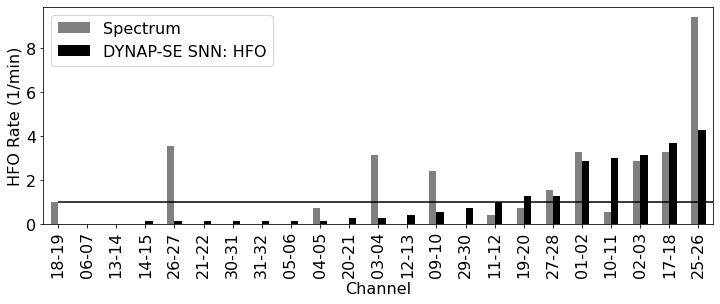

In [12]:
if(iedhfo):
    label='DYNAP-SE SNN: IED-HFO'
    color='orange'
else:
    label='DYNAP-SE SNN: HFO'
    color='black'
    
df = pd.DataFrame(np.array([SW_Rate,SNN_Rate]).T, columns=['Spectrum',label],index=list(channels))
sortedDF_SNN = df.sort_values(label)

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

bars = sortedDF_SNN.plot(kind='bar',figsize=(12,4),color=['gray',color])

plt.ylabel('HFO Rate (1/min)')
plt.xlabel('Channel')
plt.hlines([1],0,len(SW_Rate)+1,color='k')

plt.show()

In [13]:
epileptiformPatterns = [eois[l][2] for l in range(len(eois))]

In [14]:
channel='25-26'
channelID = np.where(channels==channel)[0][0]
nEV = len(epileptiformPatterns[channelID])
print('# events in channel ',channels[1],': ',nEV)

# events in channel  02-03 :  30


In [15]:
def scale(snippet):
    return (snippet-np.min(snippet))/(np.max(snippet)-np.min(snippet))

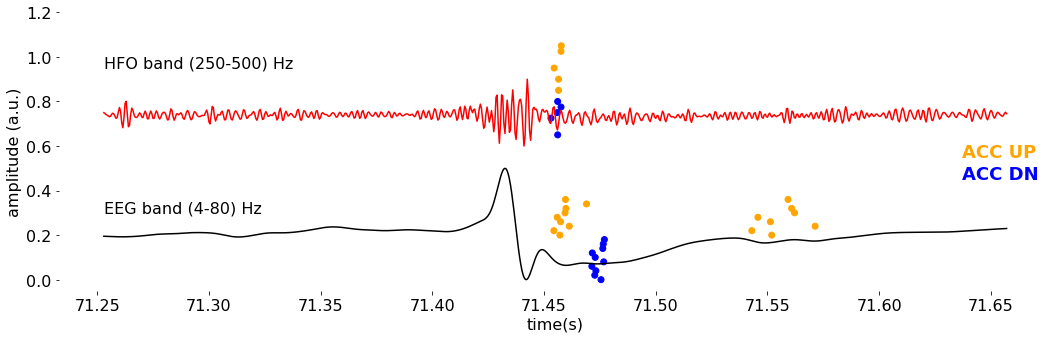

In [16]:
eventID = 5
snnTimes,snnIDs,_ = epileptiformPatterns[channelID][eventID]
maskEEG = np.array([s in range(20) for s in snnIDs])
maskHFO = ~maskEEG

hfoTimes = snnTimes[maskHFO]
hfoIDs   = snnIDs[maskHFO]
hfoC     = ['blue' if s<30 else 'orange' for s in hfoIDs]


# display event
gainHFO = 0.3
gainEEG = 0.5
vshift  = 0.6
start   = int((hfoTimes[0] -0.2)*fs)
stop    = int((hfoTimes[-1]+0.2)*fs)
xtime   = np.arange(start,stop)/fs

eegTimes = snnTimes[maskEEG]
eegIDs   = snnIDs[maskEEG]

eegIDs   = eegIDs[np.logical_and(eegTimes>(start/fs),eegTimes<(stop/fs))]
eegTimes = eegTimes[np.logical_and(eegTimes>(start/fs),eegTimes<(stop/fs))]
eegC     = ['blue' if s<10 else 'orange' for s in eegIDs]

f,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(xtime,scale(X[channelID,start:stop])*gainEEG,color='k')
ax.plot(xtime,scale(X_HFO[channelID,start:stop])*gainHFO+vshift,color='red',alpha=1)

plt.scatter(hfoTimes,np.array(hfoIDs-20)/40+vshift,c=hfoC)
plt.scatter(eegTimes,np.array(eegIDs)/50,c=eegC)

plt.xlabel('time(s)')
plt.ylabel('amplitude (a.u.)')
plt.text(xtime[0],0.30,str('EEG band (4-80) Hz'))
plt.text(xtime[0],0.95,str('HFO band (250-500) Hz'))
plt.text(xtime[-1]-0.02,0.55,str('ACC UP'),c='orange',fontsize=18,fontweight='bold')
plt.text(xtime[-1]-0.02,0.45,str('ACC DN'),c='blue',fontsize=18,fontweight='bold')

ax.spines[['right', 'top','left','bottom']].set_visible(False)
ax.set_ylim([-0.05, 1.2])
plt.tight_layout()
plt.show()